# Numerator Take Home

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
from collections import defaultdict
from statistics import mean, stdev
from math import exp
import warnings

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score, precision_score

In [3]:
np.random.seed(2168)

# EDA
### Pandas or Numpy? 
_pandas_ File size is < 1GB so pandas should be fine.

In [4]:
data = pd.read_excel("data.xlsx")

In [5]:
# excel file has some cleanup issues
data = data.apply(lambda x: x.astype(str).str.strip() if x.dtype == "object" else x)
data = data.replace("", np.nan)
data = data.replace("unknown", np.nan)

In [6]:
# get a handle on what type of data we've imported
for col, typ in data.dtypes.iteritems():
    if typ == object:
        print("{}\t{}".format(col, typ))
        print(list(data[col].unique())[:4], len(list(data[col].unique())))
    else:
        print(data[col][:5])
    print("\t")

0    125436
1     24401
2    612414
3    623415
4    319170
Name: user_id, dtype: int64
	
0    22858233
1    22883015
2    22911866
3    22912171
4    22912271
Name: basket_id, dtype: int64
	
banner_name	object
['Walmart', 'Vons', 'Safeway', 'RiteAid'] 1269
	
retailer_name	object
['Walmart', 'Safeway', 'RiteAid', 'Albertsons'] 1205
	
channel_name	object
['Mass', 'Food', 'Drug', 'Club'] 9
	
parent_channel_name	object
['FMCG'] 1
	
0    94305
1    92883
2    98368
3    93270
4    93021
Name: user_geo_postal_code, dtype: int64
	
user_geo_city	object
['Stanford', 'Corona', 'Port Townsend', 'Terra Bella'] 1053
	
user_geo_rural_code	object
['Urban', 'Suburban', 'Rural'] 3
	
user_geo_state	object
['CA', 'WA', 'MA', 'MT'] 51
	
user_geo_census_region	object
['West', 'Northeast', 'Midwest', 'South'] 5
	
user_geo_census_division	object
['Pacific', 'New England', 'Mountain', 'East North Central'] 10
	
0    1200069
1          0
2    1506246
3    1504646
4    1332228
Name: store_geo_store_id, dtype: 

In [7]:
# Let's record what those columns actually are
# Below are the columns of interest
object_cols = ["user_id", "user_geo_postal_code", "store_geo_store_id"]
float64_cols = ["store_geo_latitude", "store_geo_longitude", "salestax"]
int_cols = ["user_demo_household_size"]
ordinal_cols = [
    "user_demo_age",
    "user_demo_education",
    "user_demo_employment",
    "user_demo_income"
]
special_cols = [
    "adult_genders_on_trip",
    "other_retailers_in_shopping_trip",
    "location_during_the_shopping_trip"
]

# Below are columns of....less interest
# transcription_level?
# trip_rating?
# drop_cols = [
#     "other_banners_in_shopping_trip",
#     "location_during_the_shopping_trip",
#     "were_there_other_stores_on_this_shopping_trip",
#     "adult_genders_on_trip",
#     "kids_present_on_trip",
#     "transcription_level",
#     "basket_id",
#     "banner_name",
#     "parent_channel_name",
#     "geo_store_id",
#     "geo_store_name"
# ]

# Feature selection
Under different circumstances we might consider a wider variety of features, but for these purposes we'll pair down what we consider

First, let's convert the columns that we see are wrongly typed

In [8]:
for col in object_cols:
    data[col] = data[col].astype(object)
    
for col in float64_cols:
    data[col] = data[col].astype(float)

## Incorporate time
Time will be important to create cutoffs to test our model, create labels, and to create features that capture prior customer behavior

In [9]:
# join with time
time = pd.read_csv("basket_txn_dates.csv")

In [10]:
time["transaction_dt"] = pd.to_datetime(time["transaction_dt"], format='%Y-%m-%d')

In [11]:
time = time.set_index("basket_id")

In [12]:
data = data.set_index("basket_id")

In [13]:
data = data.join(time, how="inner")

In [14]:
data.shape # didn't lose too many--great!

(193807, 44)

## Check the date coverage

In [15]:
%matplotlib inline

In [16]:
data["transaction_dt"].describe()

count                  193807
unique                    348
top       2015-04-04 00:00:00
freq                      932
first     2014-08-31 00:00:00
last      2015-08-13 00:00:00
Name: transaction_dt, dtype: object

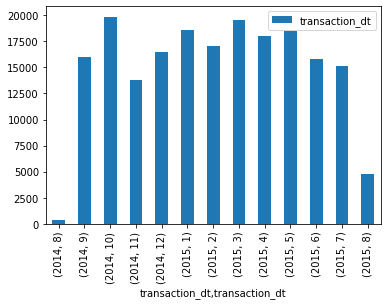

In [17]:
data[["transaction_dt"]].groupby(
    [data["transaction_dt"].dt.year, data["transaction_dt"].dt.month]
).count().plot(kind="bar")

Not too bad, relatively consistent overtime, given the usual cutoff of the first month (8-2014) and the last month (8-2015)

# Let's check those labels

First, let's check the distribution

In [18]:
retailer_counts = data[["retailer_name", "user_id"]].groupby("retailer_name").count()#.sort_values(by="user_id").plot(kind="hist")
retailer_counts["percent"] = retailer_counts["user_id"] / sum(retailer_counts["user_id"])

In [19]:
retailer_counts.columns = ["count", "percent_of_visits"]

In [20]:
retailer_counts.describe()

,count,percent_of_visits
count,1205.000000,1205.000000
mean,160.835685,0.000830
std,1405.902033,0.007254
min,1.000000,0.000005
25%,1.000000,0.000005
50%,2.000000,0.000010
75%,7.000000,0.000036
max,24198.000000,0.124856


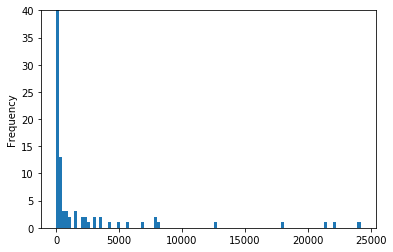

In [21]:
retailer_counts["count"].sort_values().plot(kind="hist", bins=100, ylim=(0,40))

Ah.  75% of all retailers are seen less than 8 times. And, it looks to follow a general power law distribution.
This may be a entry error, but because the formatting of the retailer names looks pretty good on spot inspection, we would be better spent asking an SME about how the retailer names are entered than trying to do a string clean up.  For right now let's assume they were entered via drop down menu or another structured data entry method.

Let's consider those that have been seen at least 1000 times.

In [22]:
SPECIAL_INTEREST = ["Walmart", "Safeway", "Dollar General"]

In [23]:
VISIT_CUTOFF = 1000

In [24]:
retailer_counts.sort_values(by="count", ascending=False, inplace=True)
retailer_counts.reset_index(inplace=True)

In [25]:
common_retailers_big = retailer_counts[retailer_counts["count"] >= VISIT_CUTOFF]
common_retailers = list(common_retailers_big["retailer_name"])
print("""There are {} retailers with at least {} visits""".format(
    len(common_retailers),VISIT_CUTOFF)
     )
common_retailers = list(set(common_retailers + SPECIAL_INTEREST))

There are 26 retailers with at least 1000 visits


# Wrangling
Let's create our data

In [26]:
ID_COLS = ["user_id", "transaction_dt"]
CUSTOMER_ATTRIBUTE_COLS = [
    'user_demo_ethnicity',
    'user_demo_age',
    'user_geo_rural_code',
    'payment_method',
    'user_demo_income'
]

In [27]:
ordinal_mappings = {
    'user_demo_age': {
        '18-20': .5,
        '21-24': .75,
        '25-34': 1,
        '35-44': 2,
        '45-54': 3,
        '55-64': 4,
        '65+': 7
    },
    'user_demo_income': {
        '- $20k':0,
        '$20k-40k': .25,
        '$40k-60k': .75,
        '$60k-80k': 1,
        '$80k-100k': 2,
        '$100k-125k': 3,
        '$125k +': 5,
    }
}

In [28]:
df_raw = data 
df_raw.reset_index(drop=True, inplace=True)

In [29]:
df = df_raw[ID_COLS].copy()

In [30]:
# it's a long line for a lambda function, but that's only due to the row names.  *shrug*
for retailer in common_retailers:
    df.loc[:, retailer] = df_raw.apply(
        lambda row: (retailer in row.retailer_name) or (retailer in row.other_retailers_in_shopping_trip),
    axis=1)    

In [31]:
attribute_feature_cols = []

for col in CUSTOMER_ATTRIBUTE_COLS:
    if df_raw[col].dtype == object:
        if col in ordinal_cols:
            df[col] = df_raw[col].map(ordinal_mappings[col])
            attribute_feature_cols += [col]
        else:
            df = df.join(pd.get_dummies(df_raw[col]))
            attribute_feature_cols += list(df_raw[col].dropna().unique())

### Let's group data by days
If the same shop is visited twice on the same day, let's consider that equivalent to one visit
For ordinal columns, let's take the largest value seen.

In [32]:
# list the columns that we'd like to aggregate as sum(x) > 0 or max

sufficient_cols = ID_COLS + common_retailers + \
    [col for col in attribute_feature_cols if col not in ordinal_cols]

max_cols = ID_COLS + [col for col in ordinal_cols if col in attribute_feature_cols]

In [33]:
by_day = df[sufficient_cols].groupby(by=ID_COLS).agg(lambda x: (sum(x) > 0))*1

by_day_max = df[max_cols].groupby(by=ID_COLS).max()

In [34]:
by_day_max -= by_day_max.min()
by_day_max /= by_day_max.max()

In [35]:
by_day = by_day.join(by_day_max)

In [36]:
by_day.reset_index(inplace=True)

# Modelling
We need two major functions:  one that'll make the data aggregations for each time split ( `make_chunked_cols` ) and one that'll rely on that and handle the rather tricky time-depenent cross validation (`cv_and_fit`).

In [37]:
def make_chunked_cols(
    data,
    label_cols,
    attribute_cols,
    sum_cols,
    days,
    earliest_date,
    predict_date,
    latest_date):
    """
    We find ourselves in the following situation:
    We need to predict whether or not an individual will shop
    at a store at least in the days following 'today' [the day of prediction].
    So, we need to create our features 'x' from only data that was available by or before
    today [the day of prediction] and we need to create our label 'y' from data
    that is from today [the day of prediction]
    unto the end of the prediction range [latest_date].
    """
    df = data.copy()
    df.dropna(inplace=True)
    
    # make y from data available after predict_date until latest_date
    if df.index.name == "user_id":
        df.reset_index(inplace=True)
    if "index" in df.columns:
        df.drop("index", axis=1, inplace=True)

    y_cols = ["user_id"] + label_cols
    y = df.loc[(df["transaction_dt"] > predict_date) & (df["transaction_dt"] < latest_date),\
              y_cols]

    aggs = {col: lambda x: (sum(x) > 1) for col in label_cols}
    
    y = y.groupby(by="user_id").agg(aggs)*1
#     y = y.div(y.sum(axis=1), axis=0)

    # make x from data available by and before the predict_date
    # make the customer attributes from the most recent record before predict_date
    df.reset_index(inplace=True)
    base_cols = ID_COLS + attribute_cols
    x = df.loc[:,base_cols].loc[df.groupby(by="user_id").transaction_dt.idxmax(),:]
    x.set_index("user_id", inplace=True)
    df.set_index("user_id", inplace=True)

    # make the shopping behavior attributes aggregated over windows
    begin_date = predict_date - timedelta(days=days)
    end_date = predict_date
    delta = 0  

    while begin_date >= earliest_date:
        
        this_df = df[(df["transaction_dt"] >= begin_date) & (df["transaction_dt"] < end_date)]
        this_df = this_df[sum_cols]
        this_df = this_df.groupby(by=this_df.index).agg(lambda x: sum(x))
        x = x.join(this_df, rsuffix="_{}".format(delta))
        end_date = begin_date
        begin_date = begin_date - timedelta(days=days)
        delta+=1

    x.fillna(0, inplace=True)
    
    # a little clean up to make sure we have a 1-to-1 between X and Y
    x["dummy"] = 0
    y = y.join(x["dummy"], how='right')
    x.drop("dummy", axis=1, inplace=True)
    y.drop("dummy", axis=1, inplace=True)
    y.fillna(0, inplace=True)

    return x, y

In [38]:
def cv_and_fit(
    df,
    predict_days=30,
    feature_days=120,
    agg_days=30,
    refit_days=10,
):
    """
    We would like to do cross validation in order to assess the stability
    of the estimated performance.
    We need to make a few sequential train/test splits in order
    to produce a time-dependent cross validation
    """
    earliest_date = df.transaction_dt.min()
    latest_date = df.transaction_dt.max()
    lag_days = refit_days + predict_days
    total_days = feature_days + predict_days
    delta = 0

    dct = {
        "label_cols": common_retailers,
        "attribute_cols": attribute_feature_cols,
        "sum_cols": common_retailers,
        "days": agg_days
    }
    
    results = defaultdict(list)
    probas_dict = defaultdict(list)
    
    # initial train/test split
    train_begin_date = earliest_date
    train_end_date = earliest_date + timedelta(days=total_days)
    test_end_date = train_end_date + timedelta(days=lag_days+predict_days)
    test_begin_date = test_end_date - timedelta(days=total_days)
    x_test, y_test = None, None

    while test_end_date < latest_date:
        
        # training data
        # if this is the earliest cv fold
        if x_test is None:
            df_training = df.loc[
                (df["transaction_dt"] > train_begin_date) & (df["transaction_dt"] < train_end_date), :
            ]

            x_train, y_train = make_chunked_cols(
                data = df_training,
                earliest_date = train_begin_date,
                predict_date =  train_end_date - timedelta(days=predict_days),
                latest_date = train_end_date,
                **dct
            )
            x_train.drop("transaction_dt", axis=1, inplace=True)
        
        # if this is a later cv split, simply add last fold's testing data
        else:
            x_train = pd.concat([x_test, x_train])
            y_train = pd.concat([y_test, y_train])

        #test data
        df_test = df.loc[
            (df["transaction_dt"] >= test_begin_date) & (df["transaction_dt"] < test_end_date), :
        ]

        x_test, y_test = make_chunked_cols(
            data = df_test,
            earliest_date = test_begin_date,
            predict_date =  test_end_date - timedelta(days=predict_days),
            latest_date = test_end_date,
            **dct
        )
        x_test.drop("transaction_dt", axis=1, inplace=True)
        
                
        probas = y_test.copy()
                
        for retailer in common_retailers:
            model = MultinomialNB(alpha=0.01)
            model.fit(x_train, y_train[retailer])
            score = model.score(x_test, y_test[retailer])
            preds = model.predict(x_test)
            results[retailer].append(recall_score(y_test[retailer], preds))
            probas[retailer] = model.predict(x_test)

        scores = []
        for user, proba in probas.iterrows():
            
            try:
                warnings.filterwarnings("error")
                score = recall_score(y_test.loc[user], proba)
                scores.append(score)
            except Warning:
                pass
            
        probas_dict[delta] = [mean(scores), stdev(scores)]

        delta+=1
            
        train_begin_date += timedelta(days=lag_days)
        train_end_date += timedelta(days=lag_days)
        test_end_date += timedelta(days=lag_days)
        test_begin_date += timedelta(days=lag_days)
        
    # final model
    x_train = pd.concat([x_test, x_train])
    y_train = pd.concat([y_test, y_train])
    
    final_models_dct = {}
    
    for retailer in common_retailers:
        model = MultinomialNB(alpha=0.01)
        model.fit(x_train, y_train[retailer])
        final_models_dct[retailer] = model
    
    return results, probas_dict, final_models_dct, x_train



In [39]:
# by_day.reset_index(inplace=True)
results, probas, final_models, x_train = cv_and_fit(by_day)

# Cross validation

### Per-retailer performance stdev

In [40]:
cv = pd.DataFrame.from_dict(results).T

In [41]:
per_retailer = cv[[cv.columns[-1]]].join(cv[cv.columns[:-1]].T.describe().T[["std"]])

### Overall performance estimate
This provides the average performance per observation (user)

In [42]:
cv_grouped = pd.DataFrame.from_dict(probas, orient="index", columns=["mean", "stdev"])

performance_est = cv_grouped.iloc[-1,0]

performance_stdev = cv_grouped.iloc[:-1].describe().loc["std", "mean"]

In [43]:
print("""Performance estimates for predicted retail group:
Recall estimate {}
standard deviation estimate {}""".format(performance_est, performance_stdev))

Performance estimates for predicted retail group:
Recall estimate 0.7320055360927296
standard deviation estimate 0.02768068418113601


## Predict retailers for new shoppers

In [44]:
example_x = x_train.iloc[0:1,:]
modl = final_models["Walmart"]

In [45]:
def predict_retailers(models=final_models, x=example_x):
    retailers = []
    for retailer, model in final_models.items():
        if model.predict(x)[0] == 1:
            retailers.append(retailer)
            
    return retailers
            

## Get most useful and least useful features

In [46]:
def features(models=final_models):
    dct = defaultdict(list)
    for retailer, model in final_models.items():
        dct[retailer] = list(model.coef_[0])
    return pd.DataFrame.from_dict(dct, orient="index", columns=example_x.columns)

In [47]:
features_importance = features()

# Most important
pd.DataFrame(features_importance.mean().sort_values(ascending=False))[:10]

,0
Target,-3.579168
Walmart,-3.587294
Target_2,-3.597687
Walmart_1,-3.630842
Walmart_2,-3.647794
Target_1,-3.668444
Target_3,-3.707468
Walmart_3,-3.778043
Safeway,-3.813969
Safeway_2,-3.868968


In [48]:
# Least important
pd.DataFrame(features_importance.mean().sort_values(ascending=True)[:10])

,0
PAYPAL,-14.434209
MONEY CARD,-13.153908
GIFTCARD,-9.727842
Dollar General_1,-8.069853
Dollar General_3,-7.981473
Bel Air Market,-7.948147
Dollar General_2,-7.904616
Bel Air Market_3,-7.837651
Bel Air Market_2,-7.748091
Dollar General,-7.576663


## Answer questions 3 & 5

In [49]:
def probability(categorical_features, models=final_models):
    dct = {}
    for retailer, model in final_models.items():
        prob = exp(list(model.class_log_prior_)[1])
        for feature in categorical_features:
            inds = [ind for ind, val in enumerate(example_x.columns) if feature in val]
            for ind in inds:
                prob*=exp(list(model.feature_log_prob_[1])[ind])
        dct[retailer] = [prob]
    return pd.DataFrame.from_dict(dct,orient="index", columns=["order"])\
            .sort_values(by="order",ascending=False)
            

In [50]:
# Walmart and Hispanic
probability(["Walmart", "Hispanic"])[:5]

,order
Walmart,1.253975e-08
Kroger,5.355962e-10
Stater Bros.,4.675544e-10
Sam's Club,4.251739e-10
Target,3.960129e-10


In [51]:
probability(["Safeway"])[:5]

,order
Safeway,1.951705e-06
Target,6.902419e-08
Costco,4.397612e-08
Trader Joe's,3.081888e-08
Walgreens,2.295639e-08


In [52]:
for retailer in common_retailers:
    print("{}:\n{}\n".format(retailer, list(probability([retailer])[:5].index)))

Grocery Outlet:
['Grocery Outlet', 'Save Mart', 'Dollar Tree', 'Food Maxx', 'Lucky']

Kroger:
['Kroger', '99 Cents Only', 'Target', 'Walmart', 'CVS']

Dollar General:
['Dollar General', 'Save Mart', 'Walmart', 'Dollar Tree', 'RiteAid']

Albertsons:
['Albertsons', 'Target', 'Walmart', 'Kroger', 'Stater Bros.']

Lucky:
['Lucky', 'Grocery Outlet', 'Safeway', "Trader Joe's", 'Walgreens']

Winco Foods:
['Winco Foods', 'Walmart', 'Grocery Outlet', 'Dollar Tree', 'Bel Air Market']

7-Eleven:
['7-Eleven', 'Walmart', 'CVS', 'Walgreens', '99 Cents Only']

99 Cents Only:
['99 Cents Only', 'Kroger', 'Walmart', 'Target', 'Stater Bros.']

Raley's:
["Raley's", 'Bel Air Market', 'Save Mart', 'Food Maxx', 'Walmart']

Stater Bros.:
['Stater Bros.', 'Walmart', 'Target', 'Albertsons', '99 Cents Only']

Safeway:
['Safeway', 'Target', 'Costco', "Trader Joe's", 'Walgreens']

Walgreens:
['Walgreens', 'Safeway', 'Food Maxx', 'Lucky', 'Target']

Trader Joe's:
["Trader Joe's", 'Whole Foods', 'Safeway', 'Sprouts 

## Question 4 Investigation

In [53]:
def feature_probability(models=final_models):
    dfs = []
    for retailer, model in final_models.items():
        dct = {}
        for ind, feature in enumerate(example_x.columns):
            prob=exp(list(model.feature_log_prob_[1])[ind])
            dct[feature] = [prob]
            
        df = pd.DataFrame.from_dict(dct, orient="index", columns=[retailer])
        df = df.sort_values(by=retailer, ascending=False)
        df.reset_index(inplace=True)
        df = df[["index"]]
        df.columns = [retailer]
        dfs.append(df)

    return pd.concat(dfs, axis=1)


In [54]:
most_common_features = feature_probability()

In [55]:
most_common_features.loc[0:20,]

,Grocery Outlet,Kroger,Dollar General,Albertsons,Lucky,Winco Foods,7-Eleven,99 Cents Only,Raley's,Stater Bros.,...,Food Maxx,Costco,Dollar Tree,CVS,Walmart,Sam's Club,Sprouts Farmers Market,Smart & Final,Fresh & Easy Neighborhood Market,Save Mart
0,Grocery Outlet_1,Kroger,Dollar General,Albertsons,Safeway,Winco Foods,7-Eleven_2,Walmart,Raley's,Stater Bros.,...,Food Maxx,Costco,Walmart_1,CVS,Walmart,Walmart,Target,Smart & Final,Fresh & Easy Neighborhood Market_2,Save Mart_1
1,Grocery Outlet,Kroger_1,Dollar General_2,Albertsons_1,Safeway_2,Winco Foods_1,7-Eleven,Walmart_1,Raley's_1,Stater Bros._1,...,Food Maxx_2,Costco_1,Walmart,CVS_2,Walmart_2,Walmart_2,Target_2,Target,Fresh & Easy Neighborhood Market,Save Mart
2,Grocery Outlet_2,Kroger_2,Dollar General_3,Albertsons_2,Lucky,Winco Foods_2,7-Eleven_1,99 Cents Only,Raley's_2,Stater Bros._2,...,Food Maxx_1,Costco_2,Walmart_2,CVS_1,Walmart_1,Walmart_1,Target_1,Target_2,Target_2,Save Mart_2
3,Grocery Outlet_3,Kroger_3,Walmart,Albertsons_3,Safeway_3,Winco Foods_3,7-Eleven_3,Walmart_2,Raley's_3,Stater Bros._3,...,Walmart,Costco_3,Walmart_3,CVS_3,Walmart_3,Sam's Club,Sprouts Farmers Market_1,Walmart_1,Target,Walmart
4,Walmart,Target,Walmart_1,Walmart,Lucky_1,Walmart,Walmart_2,99 Cents Only_1,Walmart,Walmart,...,Food Maxx_3,Target_2,Target_2,Target,Target,Sam's Club_2,Sprouts Farmers Market,Smart & Final_1,Fresh & Easy Neighborhood Market_1,Walmart_2
5,Walmart_1,Target_2,Dollar General_1,Walmart_2,Safeway_1,Walmart_1,Walmart_1,99 Cents Only_2,Target_2,Walmart_2,...,Walmart_1,Target,Target,Target_2,Target_2,Walmart_3,Target_3,Walmart,Target_1,Save Mart_3
6,Safeway,Walmart,Walmart_2,Target,Lucky_3,Walmart_2,Walmart,Walmart_3,Walmart_1,Walmart_1,...,Target,Walmart,Target_1,Target_1,Target_1,Sam's Club_1,Walmart,Smart & Final_2,Target_3,Walmart_1
7,Safeway_2,Walmart_2,Walmart_3,Walmart_1,Lucky_2,Walmart_3,Target_2,Target,Walmart_2,Walmart_3,...,Walmart_2,Target_1,Safeway,Walmart,Target_3,Sam's Club_3,Walmart_1,Walmart_2,Safeway_1,Walmart_3
8,Walmart_2,Walmart_1,Target,Target_2,Target_1,Target_2,Safeway,Target_2,Target,Target_2,...,Walmart_3,Walmart_2,Dollar Tree,Target_3,Kroger_2,Target,Safeway_2,Target_1,Safeway_2,Target
9,Safeway_1,Target_1,Target_1,Target_1,Target_2,Target,Walmart_3,Kroger,Target_1,Target,...,Target_2,Walmart_1,Safeway_2,Walmart_2,Kroger,Target_2,Safeway_1,Kroger_1,Kroger_2,Target_2


In [56]:
most_common_features.loc[0:20,["Dollar General", "Dollar Tree", "99 Cents Only"]]

,Dollar General,Dollar Tree,99 Cents Only
0,Dollar General,Walmart_1,Walmart
1,Dollar General_2,Walmart,Walmart_1
2,Dollar General_3,Walmart_2,99 Cents Only
3,Walmart,Walmart_3,Walmart_2
4,Walmart_1,Target_2,99 Cents Only_1
5,Dollar General_1,Target,99 Cents Only_2
6,Walmart_2,Target_1,Walmart_3
7,Walmart_3,Safeway,Target
8,Target,Dollar Tree,Target_2
9,Target_1,Safeway_2,Kroger
